In [1]:
from ESP301Control import RotationStage
from TLBP2Control import TLBP2

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

from time import sleep

In [2]:
stage = RotationStage()
bp2Device = TLBP2()

stage.connect()
bp2Device.connect()

0

In [3]:
stage.moveRelative(10)

0

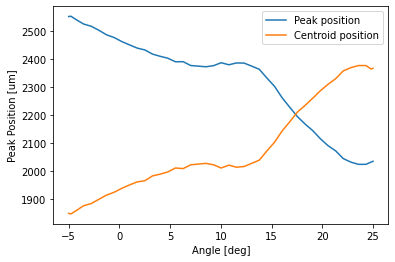

In [3]:
stage.moveRelative(30, wait=False)

peakPositionArr = []
angleArr = []
centroidArr = []

while not stage.isMoving():
    measure = bp2Device.getMeasurement()
    if measure != None:
        peakPositionArr.append(measure["gaussian_fit_params_x"][0])
        centroidArr.append(measure["centroid"][0])
        angleArr.append(stage.getAngle())
        
        clear_output(wait=True)

        plt.plot(angleArr, peakPositionArr, label="Peak position")
        plt.plot(angleArr, centroidArr, label="Centroid position")
        plt.legend()
        
        plt.xlabel("Angle [deg]")
        plt.ylabel("Peak Position [um]")
        plt.show()
    
    sleep(.2)

In [4]:
nAir = 1.0
nGlass = 1.5 # Not really, but doesn't actually matter

# Fake cuvette size, just reasonable choices
d1 = 1e-1 # Width of cuvette wall [mm]
d2 = 1 # Width of cuvette cavity [mm]

def delta(theta, dtheta=0, d1=d1, d2=d2, n0=nAir, n1=nGlass, n2=nAir):
    return (2*d1*(1 - n0 * np.cos(theta+dtheta)/np.sqrt(n1**2 - n0**2 * np.sin(theta+dtheta)**2)) + d2*(1 - n0*np.cos(theta+dtheta)/np.sqrt(n2**2 - n0**2 * np.sin(theta+dtheta)**2))) * np.sin(theta+dtheta)

Calculated phase difference 1.1196875133342177


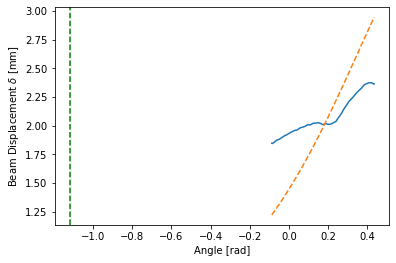

In [5]:
# Now recover the phase difference, just to confirm it can be done
from scipy.optimize import curve_fit

# Now fit our function with scipy
def wrap_func(th, phaseDiff):
    return delta(th, dtheta=phaseDiff, d1=1.5 ,d2=8, n1=1.3)

angleArr = np.array(angleArr) * np.pi/180
centroidArr = np.array(centroidArr) * 1e-3

#deltaArr = deltaArr + y_noise
popt, pcov = curve_fit(wrap_func, angleArr, centroidArr, bounds=(-np.pi/2 + .01, np.pi/2 + .01))

plt.plot(angleArr, centroidArr)
plt.plot(angleArr, wrap_func(angleArr, *popt), '--')
plt.axvline(-popt, linestyle='--', color='g')
plt.xlabel('Angle [rad]')
plt.ylabel(r'Beam Displacement $\delta$ [mm]')

#print(f'Real phase difference: {phaseDiff}')
print(f'Calculated phase difference {popt[0]}')

plt.show()

In [7]:
stage.disconnect()
bp2Device.disconnect()